In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])


class NMINSTImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images1 = np.load(img_dir_file + 'train_MNIST_Voxel1_trilinear_x_resolution.npy').astype(np.float32)
        self.labels1 = np.load(img_dir_file + 'train_MNIST_Voxel1_trilinear_y_resolution.npy')
        self.images2 = np.load(img_dir_file + 'train_MNIST_Voxel2_trilinear_x_resolution.npy').astype(np.float32)
        self.labels2 = np.load(img_dir_file + 'train_MNIST_Voxel2_trilinear_y_resolution.npy')
        self.images3 = np.load(img_dir_file + 'train_MNIST_Voxel3_trilinear_x_resolution.npy').astype(np.float32)
        self.labels3 = np.load(img_dir_file + 'train_MNIST_Voxel3_trilinear_y_resolution.npy')

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels1) + len(self.labels2) + len(self.labels3)

    def __getitem__(self, idx):
        if idx//10000 == 0:
            image = self.images1[idx%10000]
            label = self.labels1[idx%10000]
        elif idx//10000 == 1:
            image = self.images2[idx%10000]
            label = self.labels2[idx%10000]
        elif idx//10000 == 2:
            image = self.images3[idx%10000]
            label = self.labels3[idx%10000]

        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
        
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NMINSTImageDataset("Datasety/", transform=transforms)
generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.relu(out, inplace=False)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_chanels = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_chanels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.relu(x, inplace=False)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.94)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_MINST-DVS_ReLU_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected_trilinear.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_chanels=5).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, mom

### Copy weights

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): Batch

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90)

100%|██████████| 657/657 [02:42<00:00,  4.05it/s]


Epoch [1/120], Step [657/657], Loss: 5.9427, Accuracy: 0.1410
Accuracy of the network: 0.14777777777777779 Loss: 2.2598498932858733


100%|██████████| 657/657 [02:40<00:00,  4.10it/s]


Epoch [2/120], Step [657/657], Loss: 1.9825, Accuracy: 0.2162
Accuracy of the network: 0.30922222222222223 Loss: 1.8734074543553887


100%|██████████| 657/657 [02:37<00:00,  4.16it/s]


Epoch [3/120], Step [657/657], Loss: 1.5723, Accuracy: 0.3734
Accuracy of the network: 0.4841111111111111 Loss: 1.2737317985676704


100%|██████████| 657/657 [02:37<00:00,  4.18it/s]


Epoch [4/120], Step [657/657], Loss: 1.1150, Accuracy: 0.5769
Accuracy of the network: 0.5628888888888889 Loss: 1.119619628427722


100%|██████████| 657/657 [02:36<00:00,  4.20it/s]


Epoch [5/120], Step [657/657], Loss: 0.9175, Accuracy: 0.6548
Accuracy of the network: 0.7051111111111111 Loss: 0.8094323013268464


100%|██████████| 657/657 [02:32<00:00,  4.32it/s]


Epoch [6/120], Step [657/657], Loss: 0.8567, Accuracy: 0.6847
Accuracy of the network: 0.6973333333333334 Loss: 0.8232366824192359


100%|██████████| 657/657 [02:34<00:00,  4.25it/s]


Epoch [7/120], Step [657/657], Loss: 0.8160, Accuracy: 0.6997
Accuracy of the network: 0.6942222222222222 Loss: 0.8338438286214855


100%|██████████| 657/657 [02:35<00:00,  4.22it/s]


Epoch [8/120], Step [657/657], Loss: 0.7937, Accuracy: 0.7137
Accuracy of the network: 0.6823333333333333 Loss: 0.8594517680347389


100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Epoch [9/120], Step [657/657], Loss: 0.7569, Accuracy: 0.7261
Accuracy of the network: 0.6823333333333333 Loss: 0.8578453470840521


100%|██████████| 657/657 [02:31<00:00,  4.34it/s]


Epoch [10/120], Step [657/657], Loss: 0.7305, Accuracy: 0.7341
Accuracy of the network: 0.7554444444444445 Loss: 0.665454922838414


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [11/120], Step [657/657], Loss: 0.7151, Accuracy: 0.7445
Accuracy of the network: 0.7766666666666666 Loss: 0.6359415381407061


100%|██████████| 657/657 [02:32<00:00,  4.30it/s]


Epoch [12/120], Step [657/657], Loss: 0.6906, Accuracy: 0.7488
Accuracy of the network: 0.773 Loss: 0.6272313023078526


100%|██████████| 657/657 [02:32<00:00,  4.32it/s]


Epoch [13/120], Step [657/657], Loss: 0.6600, Accuracy: 0.7625
Accuracy of the network: 0.8187777777777778 Loss: 0.5213691095511118


100%|██████████| 657/657 [02:36<00:00,  4.21it/s]


Epoch [14/120], Step [657/657], Loss: 0.6442, Accuracy: 0.7718
Accuracy of the network: 0.8363333333333334 Loss: 0.4786137474555496


100%|██████████| 657/657 [02:31<00:00,  4.32it/s]


Epoch [15/120], Step [657/657], Loss: 0.6112, Accuracy: 0.7836
Accuracy of the network: 0.7657777777777778 Loss: 0.6435050959071369


100%|██████████| 657/657 [02:31<00:00,  4.33it/s]


Epoch [16/120], Step [657/657], Loss: 0.6034, Accuracy: 0.7836
Accuracy of the network: 0.802 Loss: 0.5594316215274182


100%|██████████| 657/657 [02:35<00:00,  4.23it/s]


Epoch [17/120], Step [657/657], Loss: 0.5977, Accuracy: 0.7832
Accuracy of the network: 0.8308888888888889 Loss: 0.516437938925645


100%|██████████| 657/657 [02:34<00:00,  4.26it/s]


Epoch [18/120], Step [657/657], Loss: 0.5721, Accuracy: 0.7995
Accuracy of the network: 0.8365555555555556 Loss: 0.4589490170280139


100%|██████████| 657/657 [02:32<00:00,  4.30it/s]


Epoch [19/120], Step [657/657], Loss: 0.5567, Accuracy: 0.8067
Accuracy of the network: 0.7772222222222223 Loss: 0.6206277389581322


100%|██████████| 657/657 [02:34<00:00,  4.25it/s]


Epoch [20/120], Step [657/657], Loss: 0.5357, Accuracy: 0.8109
Accuracy of the network: 0.8184444444444444 Loss: 0.5353102307793096


100%|██████████| 657/657 [02:29<00:00,  4.41it/s]


Epoch [21/120], Step [657/657], Loss: 0.5164, Accuracy: 0.8216
Accuracy of the network: 0.8516666666666667 Loss: 0.4292026535204962


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [22/120], Step [657/657], Loss: 0.5158, Accuracy: 0.8197
Accuracy of the network: 0.8586666666666667 Loss: 0.4314762568431543


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [23/120], Step [657/657], Loss: 0.4884, Accuracy: 0.8282
Accuracy of the network: 0.861 Loss: 0.4269090795770605


100%|██████████| 657/657 [02:31<00:00,  4.33it/s]


Epoch [24/120], Step [657/657], Loss: 0.4835, Accuracy: 0.8323
Accuracy of the network: 0.8311111111111111 Loss: 0.49550940450413006


100%|██████████| 657/657 [02:30<00:00,  4.37it/s]


Epoch [25/120], Step [657/657], Loss: 0.4637, Accuracy: 0.8409
Accuracy of the network: 0.8654444444444445 Loss: 0.4021503712374268


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [26/120], Step [657/657], Loss: 0.4605, Accuracy: 0.8419
Accuracy of the network: 0.855 Loss: 0.42411227788485534


100%|██████████| 657/657 [02:29<00:00,  4.40it/s]


Epoch [27/120], Step [657/657], Loss: 0.4411, Accuracy: 0.8489
Accuracy of the network: 0.86 Loss: 0.4155022260726344


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [28/120], Step [657/657], Loss: 0.4393, Accuracy: 0.8472
Accuracy of the network: 0.877 Loss: 0.38027600962536556


100%|██████████| 657/657 [02:27<00:00,  4.46it/s]


Epoch [29/120], Step [657/657], Loss: 0.4235, Accuracy: 0.8561
Accuracy of the network: 0.8952222222222223 Loss: 0.33512477008691915


100%|██████████| 657/657 [02:28<00:00,  4.41it/s]


Epoch [30/120], Step [657/657], Loss: 0.4180, Accuracy: 0.8603
Accuracy of the network: 0.8897777777777778 Loss: 0.34022713759055373


100%|██████████| 657/657 [02:28<00:00,  4.43it/s]


Epoch [31/120], Step [657/657], Loss: 0.4003, Accuracy: 0.8673
Accuracy of the network: 0.8875555555555555 Loss: 0.35236356851268325


100%|██████████| 657/657 [02:27<00:00,  4.45it/s]


Epoch [32/120], Step [657/657], Loss: 0.3907, Accuracy: 0.8686
Accuracy of the network: 0.8818888888888889 Loss: 0.35823756913449745


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [33/120], Step [657/657], Loss: 0.3853, Accuracy: 0.8696
Accuracy of the network: 0.8827777777777778 Loss: 0.35208677434435126


100%|██████████| 657/657 [02:30<00:00,  4.35it/s]


Epoch [34/120], Step [657/657], Loss: 0.3718, Accuracy: 0.8751
Accuracy of the network: 0.8767777777777778 Loss: 0.3538339283607953


100%|██████████| 657/657 [02:27<00:00,  4.44it/s]


Epoch [35/120], Step [657/657], Loss: 0.3630, Accuracy: 0.8793
Accuracy of the network: 0.8963333333333333 Loss: 0.32368309637333487


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [36/120], Step [657/657], Loss: 0.3593, Accuracy: 0.8810
Accuracy of the network: 0.9061111111111111 Loss: 0.29110142065489547


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [37/120], Step [657/657], Loss: 0.3347, Accuracy: 0.8883
Accuracy of the network: 0.9071111111111111 Loss: 0.2831282614340596


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [38/120], Step [657/657], Loss: 0.3328, Accuracy: 0.8908
Accuracy of the network: 0.9083333333333333 Loss: 0.2883489942904694


100%|██████████| 657/657 [02:29<00:00,  4.40it/s]


Epoch [39/120], Step [657/657], Loss: 0.3373, Accuracy: 0.8870
Accuracy of the network: 0.9134444444444444 Loss: 0.28232946434447953


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [40/120], Step [657/657], Loss: 0.3170, Accuracy: 0.8961
Accuracy of the network: 0.8977777777777778 Loss: 0.30375789861518443


100%|██████████| 657/657 [02:28<00:00,  4.41it/s]


Epoch [41/120], Step [657/657], Loss: 0.3084, Accuracy: 0.9013
Accuracy of the network: 0.9132222222222223 Loss: 0.2634969112060383


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [42/120], Step [657/657], Loss: 0.3018, Accuracy: 0.9014
Accuracy of the network: 0.9158888888888889 Loss: 0.2683910482847099


100%|██████████| 657/657 [02:30<00:00,  4.36it/s]


Epoch [43/120], Step [657/657], Loss: 0.2945, Accuracy: 0.9063
Accuracy of the network: 0.9182222222222223 Loss: 0.25598744172206583


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [44/120], Step [657/657], Loss: 0.2922, Accuracy: 0.9049
Accuracy of the network: 0.9225555555555556 Loss: 0.24932147702532456


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [45/120], Step [657/657], Loss: 0.2850, Accuracy: 0.9059
Accuracy of the network: 0.9281111111111111 Loss: 0.2387195986873926


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [46/120], Step [657/657], Loss: 0.2656, Accuracy: 0.9151
Accuracy of the network: 0.9283333333333333 Loss: 0.2301590299590471


100%|██████████| 657/657 [02:30<00:00,  4.37it/s]


Epoch [47/120], Step [657/657], Loss: 0.2680, Accuracy: 0.9140
Accuracy of the network: 0.9177777777777778 Loss: 0.2571066028524375


100%|██████████| 657/657 [02:31<00:00,  4.33it/s]


Epoch [48/120], Step [657/657], Loss: 0.2711, Accuracy: 0.9111
Accuracy of the network: 0.928 Loss: 0.23418174084302382


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [49/120], Step [657/657], Loss: 0.2574, Accuracy: 0.9179
Accuracy of the network: 0.925 Loss: 0.2387474713886672


100%|██████████| 657/657 [02:36<00:00,  4.21it/s]


Epoch [50/120], Step [657/657], Loss: 0.2495, Accuracy: 0.9220
Accuracy of the network: 0.9273333333333333 Loss: 0.23060835900564566


100%|██████████| 657/657 [02:46<00:00,  3.94it/s]


Epoch [51/120], Step [657/657], Loss: 0.2453, Accuracy: 0.9218
Accuracy of the network: 0.9348888888888889 Loss: 0.21139625932836364


100%|██████████| 657/657 [02:46<00:00,  3.95it/s]


Epoch [52/120], Step [657/657], Loss: 0.2385, Accuracy: 0.9232
Accuracy of the network: 0.9372222222222222 Loss: 0.2128991650826965


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [53/120], Step [657/657], Loss: 0.2297, Accuracy: 0.9292
Accuracy of the network: 0.9378888888888889 Loss: 0.20575070650653637


100%|██████████| 657/657 [02:36<00:00,  4.20it/s]


Epoch [54/120], Step [657/657], Loss: 0.2192, Accuracy: 0.9318
Accuracy of the network: 0.9405555555555556 Loss: 0.19868499356328595


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [55/120], Step [657/657], Loss: 0.2239, Accuracy: 0.9294
Accuracy of the network: 0.9375555555555556 Loss: 0.20084073845666986


100%|██████████| 657/657 [02:30<00:00,  4.35it/s]


Epoch [56/120], Step [657/657], Loss: 0.2177, Accuracy: 0.9317
Accuracy of the network: 0.9396666666666667 Loss: 0.19859887345476038


100%|██████████| 657/657 [02:35<00:00,  4.22it/s]


Epoch [57/120], Step [657/657], Loss: 0.2163, Accuracy: 0.9320
Accuracy of the network: 0.942 Loss: 0.19177123203424487


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [58/120], Step [657/657], Loss: 0.2085, Accuracy: 0.9351
Accuracy of the network: 0.9391111111111111 Loss: 0.19175698971441874


100%|██████████| 657/657 [02:30<00:00,  4.36it/s]


Epoch [59/120], Step [657/657], Loss: 0.2084, Accuracy: 0.9357
Accuracy of the network: 0.9372222222222222 Loss: 0.20338448351711458


100%|██████████| 657/657 [02:28<00:00,  4.42it/s]


Epoch [60/120], Step [657/657], Loss: 0.2009, Accuracy: 0.9367
Accuracy of the network: 0.9471111111111111 Loss: 0.17706030236345763


100%|██████████| 657/657 [02:35<00:00,  4.23it/s]


Epoch [61/120], Step [657/657], Loss: 0.1958, Accuracy: 0.9385
Accuracy of the network: 0.9475555555555556 Loss: 0.17756816171479564


100%|██████████| 657/657 [02:35<00:00,  4.21it/s]


Epoch [62/120], Step [657/657], Loss: 0.1935, Accuracy: 0.9383
Accuracy of the network: 0.945 Loss: 0.1818902644639214


100%|██████████| 657/657 [02:35<00:00,  4.23it/s]


Epoch [63/120], Step [657/657], Loss: 0.1936, Accuracy: 0.9394
Accuracy of the network: 0.9483333333333334 Loss: 0.18067169688800547


100%|██████████| 657/657 [02:35<00:00,  4.23it/s]


Epoch [64/120], Step [657/657], Loss: 0.1878, Accuracy: 0.9398
Accuracy of the network: 0.9472222222222222 Loss: 0.16904787512509323


100%|██████████| 657/657 [02:36<00:00,  4.19it/s]


Epoch [65/120], Step [657/657], Loss: 0.1874, Accuracy: 0.9422
Accuracy of the network: 0.9515555555555556 Loss: 0.16204900065344488


100%|██████████| 657/657 [02:37<00:00,  4.18it/s]


Epoch [66/120], Step [657/657], Loss: 0.1832, Accuracy: 0.9441
Accuracy of the network: 0.9494444444444444 Loss: 0.1619116327731956


100%|██████████| 657/657 [02:31<00:00,  4.33it/s]


Epoch [67/120], Step [657/657], Loss: 0.1822, Accuracy: 0.9435
Accuracy of the network: 0.9466666666666667 Loss: 0.16942747701487854


100%|██████████| 657/657 [02:31<00:00,  4.34it/s]


Epoch [68/120], Step [657/657], Loss: 0.1744, Accuracy: 0.9464
Accuracy of the network: 0.9502222222222222 Loss: 0.1659722522971161


100%|██████████| 657/657 [02:31<00:00,  4.34it/s]


Epoch [69/120], Step [657/657], Loss: 0.1780, Accuracy: 0.9476
Accuracy of the network: 0.9495555555555556 Loss: 0.16157846551071456


100%|██████████| 657/657 [02:31<00:00,  4.35it/s]


Epoch [70/120], Step [657/657], Loss: 0.1704, Accuracy: 0.9465
Accuracy of the network: 0.9534444444444444 Loss: 0.15998449963220257


100%|██████████| 657/657 [02:31<00:00,  4.35it/s]


Epoch [71/120], Step [657/657], Loss: 0.1686, Accuracy: 0.9483
Accuracy of the network: 0.9538888888888889 Loss: 0.15590850732137337


100%|██████████| 657/657 [02:31<00:00,  4.33it/s]


Epoch [72/120], Step [657/657], Loss: 0.1676, Accuracy: 0.9484
Accuracy of the network: 0.9505555555555556 Loss: 0.16450894584033823


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [73/120], Step [657/657], Loss: 0.1708, Accuracy: 0.9478
Accuracy of the network: 0.952 Loss: 0.15145603419737297


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [74/120], Step [657/657], Loss: 0.1650, Accuracy: 0.9491
Accuracy of the network: 0.9536666666666667 Loss: 0.1520428869424137


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [75/120], Step [657/657], Loss: 0.1617, Accuracy: 0.9505
Accuracy of the network: 0.9503333333333334 Loss: 0.16275775744348553


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [76/120], Step [657/657], Loss: 0.1579, Accuracy: 0.9509
Accuracy of the network: 0.9561111111111111 Loss: 0.15013273992965406


100%|██████████| 657/657 [02:29<00:00,  4.38it/s]


Epoch [77/120], Step [657/657], Loss: 0.1538, Accuracy: 0.9534
Accuracy of the network: 0.9554444444444444 Loss: 0.15382576863948547


100%|██████████| 657/657 [02:29<00:00,  4.39it/s]


Epoch [78/120], Step [657/657], Loss: 0.1598, Accuracy: 0.9507
Accuracy of the network: 0.9546666666666667 Loss: 0.1528343040073383


100%|██████████| 657/657 [02:31<00:00,  4.35it/s]


Epoch [79/120], Step [657/657], Loss: 0.1566, Accuracy: 0.9513
Accuracy of the network: 0.957 Loss: 0.14564292207492371


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [80/120], Step [657/657], Loss: 0.1522, Accuracy: 0.9530
Accuracy of the network: 0.9551111111111111 Loss: 0.14699307707607323


100%|██████████| 657/657 [02:36<00:00,  4.20it/s]


Epoch [81/120], Step [657/657], Loss: 0.1539, Accuracy: 0.9523
Accuracy of the network: 0.9565555555555556 Loss: 0.14322834037878412


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [82/120], Step [657/657], Loss: 0.1516, Accuracy: 0.9534
Accuracy of the network: 0.9566666666666667 Loss: 0.14812301739006706


100%|██████████| 657/657 [02:31<00:00,  4.32it/s]


Epoch [83/120], Step [657/657], Loss: 0.1490, Accuracy: 0.9540
Accuracy of the network: 0.9557777777777777 Loss: 0.14398740052991937


100%|██████████| 657/657 [02:34<00:00,  4.26it/s]


Epoch [84/120], Step [657/657], Loss: 0.1490, Accuracy: 0.9547
Accuracy of the network: 0.9564444444444444 Loss: 0.14262901693054125


100%|██████████| 657/657 [02:32<00:00,  4.29it/s]


Epoch [85/120], Step [657/657], Loss: 0.1467, Accuracy: 0.9554
Accuracy of the network: 0.9564444444444444 Loss: 0.14066937043668426


100%|██████████| 657/657 [02:32<00:00,  4.32it/s]


Epoch [86/120], Step [657/657], Loss: 0.1457, Accuracy: 0.9561
Accuracy of the network: 0.9597777777777777 Loss: 0.13868992948072387


100%|██████████| 657/657 [02:32<00:00,  4.31it/s]


Epoch [87/120], Step [657/657], Loss: 0.1462, Accuracy: 0.9549
Accuracy of the network: 0.9572222222222222 Loss: 0.13948279570999508


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [88/120], Step [657/657], Loss: 0.1458, Accuracy: 0.9555
Accuracy of the network: 0.9575555555555556 Loss: 0.1443302009901996


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [89/120], Step [657/657], Loss: 0.1407, Accuracy: 0.9573
Accuracy of the network: 0.9603333333333334 Loss: 0.140613112090063


100%|██████████| 657/657 [02:36<00:00,  4.19it/s]


Epoch [90/120], Step [657/657], Loss: 0.1454, Accuracy: 0.9550
Accuracy of the network: 0.9602222222222222 Loss: 0.1336634965177546


100%|██████████| 657/657 [02:35<00:00,  4.24it/s]


Epoch [91/120], Step [657/657], Loss: 0.1405, Accuracy: 0.9576
Accuracy of the network: 0.9593333333333334 Loss: 0.1393613098783696


100%|██████████| 657/657 [02:34<00:00,  4.24it/s]


Epoch [92/120], Step [657/657], Loss: 0.1416, Accuracy: 0.9569
Accuracy of the network: 0.9586666666666667 Loss: 0.13673539560103248


100%|██████████| 657/657 [02:35<00:00,  4.24it/s]


Epoch [93/120], Step [657/657], Loss: 0.1408, Accuracy: 0.9580
Accuracy of the network: 0.959 Loss: 0.1378450644605443


100%|██████████| 657/657 [02:46<00:00,  3.95it/s]


Epoch [94/120], Step [657/657], Loss: 0.1397, Accuracy: 0.9596
Accuracy of the network: 0.9575555555555556 Loss: 0.13771772684516215


100%|██████████| 657/657 [02:39<00:00,  4.12it/s]


Epoch [95/120], Step [657/657], Loss: 0.1400, Accuracy: 0.9574
Accuracy of the network: 0.9584444444444444 Loss: 0.1434169743302549


100%|██████████| 657/657 [02:34<00:00,  4.26it/s]


Epoch [96/120], Step [657/657], Loss: 0.1382, Accuracy: 0.9599
Accuracy of the network: 0.9583333333333334 Loss: 0.13693186520526174


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [97/120], Step [657/657], Loss: 0.1404, Accuracy: 0.9571
Accuracy of the network: 0.9577777777777777 Loss: 0.13756981886203354


100%|██████████| 657/657 [02:38<00:00,  4.15it/s]


Epoch [98/120], Step [657/657], Loss: 0.1354, Accuracy: 0.9588
Accuracy of the network: 0.9593333333333334 Loss: 0.13952407980971832


100%|██████████| 657/657 [02:45<00:00,  3.97it/s]


Epoch [99/120], Step [657/657], Loss: 0.1405, Accuracy: 0.9568
Accuracy of the network: 0.9564444444444444 Loss: 0.1374681002876543


100%|██████████| 657/657 [02:44<00:00,  3.98it/s]


Epoch [100/120], Step [657/657], Loss: 0.1368, Accuracy: 0.9580
Accuracy of the network: 0.9612222222222222 Loss: 0.13682984740387463


100%|██████████| 657/657 [02:34<00:00,  4.24it/s]


Epoch [101/120], Step [657/657], Loss: 0.1384, Accuracy: 0.9578
Accuracy of the network: 0.9603333333333334 Loss: 0.13719537258412398


100%|██████████| 657/657 [02:37<00:00,  4.17it/s]


Epoch [102/120], Step [657/657], Loss: 0.1348, Accuracy: 0.9605
Accuracy of the network: 0.9601111111111111 Loss: 0.1331029261812462


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [103/120], Step [657/657], Loss: 0.1355, Accuracy: 0.9607
Accuracy of the network: 0.959 Loss: 0.1341525605774042


100%|██████████| 657/657 [02:33<00:00,  4.28it/s]


Epoch [104/120], Step [657/657], Loss: 0.1388, Accuracy: 0.9571
Accuracy of the network: 0.9587777777777777 Loss: 0.1356212834246351


100%|██████████| 657/657 [02:38<00:00,  4.14it/s]


Epoch [105/120], Step [657/657], Loss: 0.1338, Accuracy: 0.9598
Accuracy of the network: 0.9585555555555556 Loss: 0.13678612414060543


100%|██████████| 657/657 [02:38<00:00,  4.15it/s]


Epoch [106/120], Step [657/657], Loss: 0.1360, Accuracy: 0.9599
Accuracy of the network: 0.9587777777777777 Loss: 0.13971701014047186


100%|██████████| 657/657 [02:35<00:00,  4.23it/s]


Epoch [107/120], Step [657/657], Loss: 0.1334, Accuracy: 0.9606
Accuracy of the network: 0.959 Loss: 0.13532136854920404


100%|██████████| 657/657 [02:42<00:00,  4.05it/s]


Epoch [108/120], Step [657/657], Loss: 0.1320, Accuracy: 0.9601
Accuracy of the network: 0.961 Loss: 0.13406596217529043


100%|██████████| 657/657 [02:41<00:00,  4.07it/s]


Epoch [109/120], Step [657/657], Loss: 0.1334, Accuracy: 0.9595
Accuracy of the network: 0.9604444444444444 Loss: 0.1338509321873281


100%|██████████| 657/657 [02:32<00:00,  4.30it/s]


Epoch [110/120], Step [657/657], Loss: 0.1286, Accuracy: 0.9613
Accuracy of the network: 0.9596666666666667 Loss: 0.12862577349779772


100%|██████████| 657/657 [02:34<00:00,  4.25it/s]


Epoch [111/120], Step [657/657], Loss: 0.1369, Accuracy: 0.9574
Accuracy of the network: 0.961 Loss: 0.1344420257559482


100%|██████████| 657/657 [02:35<00:00,  4.23it/s]


Epoch [112/120], Step [657/657], Loss: 0.1351, Accuracy: 0.9591
Accuracy of the network: 0.9616666666666667 Loss: 0.12846448510251146


100%|██████████| 657/657 [02:43<00:00,  4.01it/s]


Epoch [113/120], Step [657/657], Loss: 0.1333, Accuracy: 0.9599
Accuracy of the network: 0.9614444444444444 Loss: 0.13297590751742536


100%|██████████| 657/657 [02:42<00:00,  4.04it/s]


Epoch [114/120], Step [657/657], Loss: 0.1294, Accuracy: 0.9609
Accuracy of the network: 0.9593333333333334 Loss: 0.13373254030176723


100%|██████████| 657/657 [02:42<00:00,  4.05it/s]


Epoch [115/120], Step [657/657], Loss: 0.1311, Accuracy: 0.9621
Accuracy of the network: 0.9596666666666667 Loss: 0.13330473091968514


100%|██████████| 657/657 [02:37<00:00,  4.18it/s]


Epoch [116/120], Step [657/657], Loss: 0.1288, Accuracy: 0.9623
Accuracy of the network: 0.9614444444444444 Loss: 0.13179764154875742


100%|██████████| 657/657 [02:36<00:00,  4.19it/s]


Epoch [117/120], Step [657/657], Loss: 0.1295, Accuracy: 0.9601
Accuracy of the network: 0.9603333333333334 Loss: 0.13120483580633258


100%|██████████| 657/657 [02:36<00:00,  4.20it/s]


Epoch [118/120], Step [657/657], Loss: 0.1321, Accuracy: 0.9601
Accuracy of the network: 0.9624444444444444 Loss: 0.13115775560735599


100%|██████████| 657/657 [02:41<00:00,  4.06it/s]


Epoch [119/120], Step [657/657], Loss: 0.1348, Accuracy: 0.9599
Accuracy of the network: 0.9578888888888889 Loss: 0.13319320310277086


100%|██████████| 657/657 [02:38<00:00,  4.13it/s]


Epoch [120/120], Step [657/657], Loss: 0.1281, Accuracy: 0.9633
Accuracy of the network: 0.9602222222222222 Loss: 0.1326819609368471


In [10]:
torch.save(model, "best_resnet50_MINST-DVS_ReLU_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_trilinear.pt")


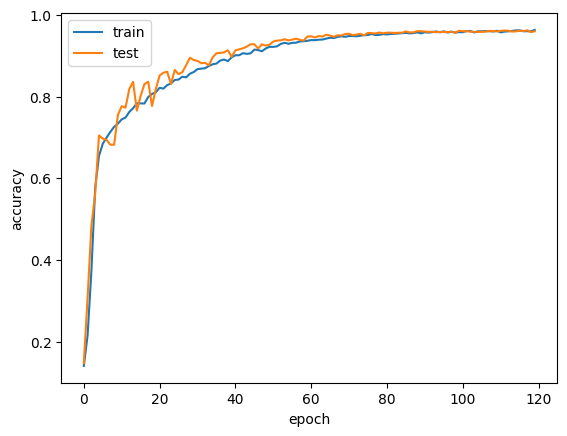

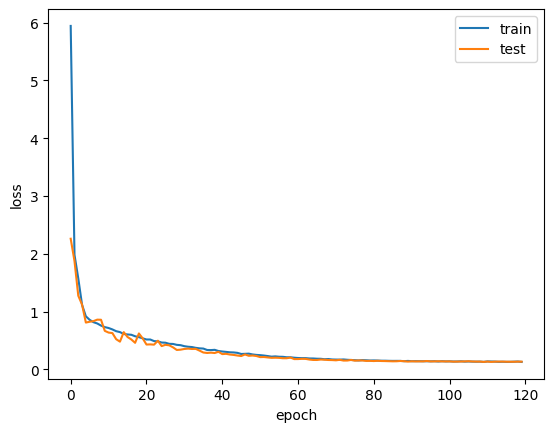

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet50_MINST-DVS_ReLU_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_trilinear.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.141000,0.147778,5.942679,2.259850
1,0.216238,0.309222,1.982486,1.873407
2,0.373429,0.484111,1.572314,1.273732
3,0.576857,0.562889,1.114982,1.119620
4,0.654762,0.705111,0.917516,0.809432


In [14]:
print(df["test_acc"].max())

0.9624444444444444


In [15]:
print(df.to_string())

     train_acc  test_acc  train_loss  test_loss
0     0.141000  0.147778    5.942679   2.259850
1     0.216238  0.309222    1.982486   1.873407
2     0.373429  0.484111    1.572314   1.273732
3     0.576857  0.562889    1.114982   1.119620
4     0.654762  0.705111    0.917516   0.809432
5     0.684714  0.697333    0.856705   0.823237
6     0.699714  0.694222    0.815975   0.833844
7     0.713714  0.682333    0.793726   0.859452
8     0.726095  0.682333    0.756945   0.857845
9     0.734095  0.755444    0.730484   0.665455
10    0.744476  0.776667    0.715063   0.635942
11    0.748810  0.773000    0.690560   0.627231
12    0.762476  0.818778    0.659956   0.521369
13    0.771810  0.836333    0.644168   0.478614
14    0.783571  0.765778    0.611151   0.643505
15    0.783571  0.802000    0.603356   0.559432
16    0.783238  0.830889    0.597701   0.516438
17    0.799476  0.836556    0.572091   0.458949
18    0.806667  0.777222    0.556726   0.620628
19    0.810857  0.818444    0.535685   0